# Problem Set 2

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on bCourses). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of surveys conducted in 1998
 * "Wave 2" of surveys conducted in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from bCourses. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|

---

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean, standard error, and the values at the 5th and 95th percentiles) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

*Note:* For this and subsequent problems, you will need to be careful in how you deal with missing (NULL) values. You should not blindly drop rows and columns where any data field is missing.  For instance, in calculating the average `hohwag`, you should average the `hohwag` values from all households that report a value (even if the household does not have a recorded `age` value, for example). 

In [1]:
# your code here
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
progresa_df = pd.read_csv('progresa_sample.csv')
print(progresa_df.head())

   year  sex  indig  dist_sec   sc  grc  fam_n   min_dist   dist_cap   poor  \
0    97  0.0    0.0     4.473  1.0  7.0      7  21.168384  21.168384  pobre   
1    98  0.0    0.0     4.473  1.0  8.0      7  21.168384  21.168384  pobre   
2    97  1.0    0.0     4.473  1.0  6.0      7  21.168384  21.168384  pobre   
3    98  1.0    0.0     4.473  1.0  7.0      7  21.168384  21.168384  pobre   
4    97  0.0    0.0     4.473  1.0  2.0      7  21.168384  21.168384  pobre   

   ... hohedu  hohwag  welfare_index  hohsex  hohage  age  village  folnum  \
0  ...      6     0.0          583.0     1.0    35.0   13      163       1   
1  ...      6     0.0          583.0     1.0    35.0   14      163       1   
2  ...      6     0.0          583.0     1.0    35.0   12      163       2   
3  ...      6     0.0          583.0     1.0    35.0   13      163       2   
4  ...      6     0.0          583.0     1.0    35.0    8      163       3   

   grc97  sc97  
0      7   1.0  
1      7   1.0  
2    

In [4]:
print('poor levels: ', progresa_df['poor'].unique().tolist())
print('progresa levels: ', progresa_df['progresa'].unique().tolist())

poor levels:  ['pobre', 'no pobre']
progresa levels:  ['0', 'basal']


In [5]:
# create dictionary to convert 'poor' values to int
poor_dict = {"no pobre":0 ,"pobre":1} 
# create new variable with pobre dictionary
progresa_df['poor'] = progresa_df['poor'].replace(poor_dict)
# # convert poor to integer
progresa_df['poor'] = pd.to_numeric(progresa_df['poor'])

In [6]:
# create dictionary to convert 'progresa' values to int
progresa_dict = {"0":0 , "basal":1}

# create new variable with pobre dictionary
progresa_df['progresa'] = progresa_df['progresa'].replace(progresa_dict)
# convert poor to integer
progresa_df['progresa'] = pd.to_numeric(progresa_df['progresa'])

In [7]:
# drop unnecessary variables (year, folnmum, village)
progresa_demog_df = progresa_df.drop(['year', 'village', 'folnum'], axis = 1)

In [8]:
# print summary stats table. Standard error is standard deviation / square root of the number of observations (OR use .sem())
pd.options.display.float_format = '{:8.3f}'.format # Set formating for displaying tables
summ_stats_df = progresa_demog_df.describe(percentiles = [0.05, 0.95]).T[['mean','std', '5%', '95%']].sort_index()
summ_stats_df['std'] = summ_stats_df['std'] / np.sqrt(progresa_demog_df.shape[0])
summ_stats_df = summ_stats_df.rename(columns = {'std':'se'})
summ_stats_df

,mean,se,5%,95%
age,11.366,0.011,7.000,16.000
dist_cap,147.674,0.274,43.886,289.016
dist_sec,2.419,0.008,0.000,5.875
fam_n,7.216,0.008,4.000,11.000
grc,3.964,0.009,0.000,8.000
grc97,3.705,0.009,0.000,8.000
hohage,44.437,0.042,29.000,66.000
hohedu,2.768,0.010,0.000,7.000
hohsex,0.925,0.001,0.000,1.000
hohwag,586.985,2.836,0.000,1440.000


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages?  Present your results in a single table with the following columns and 14 (or so) rows (alphabetized by variable name):


| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|

 *Hint:* Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 from poor households (i.e., poor=='pobre').


In [9]:
# your code here
# Generate data frame with only 1997 data and with only poor households
pre_poor_df = progresa_df[(progresa_df['year'] == 97) & (progresa_df['poor'] == 1)]

# create treatment data frame with poor households
pre_treat = pre_poor_df[pre_poor_df['progresa'] == 1]

# create control data frame with poor households
pre_control = pre_poor_df[pre_poor_df['progresa'] == 0]

In [10]:
# drop unecessary variables for demographic characteristics
pre_treat_demog = pre_treat.drop(['poor', 'progresa', 'year', 'village', 'folnum', 'sc', 'grc'], axis = 1)
pre_control_demog = pre_control.drop(['poor', 'progresa', 'year', 'village', 'folnum', 'sc', 'grc'], axis = 1)

In [11]:
# Create data frame with p-values
means_t = []
means_c = []
diffs = []
pvalues = []
demogvars = pre_control_demog.columns.tolist()
for var in demogvars:
    #print var
    x_t = pre_treat_demog[var].dropna().mean()
    x_c = pre_control_demog[var].dropna().mean()   
    diff = x_t - x_c
    result = stats.ttest_ind(pre_treat_demog[var].dropna(), pre_control_demog[var].dropna())
    means_t.append(x_t)
    means_c.append(x_c)
    diffs.append(diff)
    pvalues.append(result[1])

mean_compare = pd.DataFrame({'Variable name':demogvars,
                             'Average value (Treatment villages)':means_t,
                             'Average value (Control villages)':means_c,
                             'Difference (Treat - Control)':diffs,
                             'p-value':pvalues})

In [12]:
pd.options.display.float_format = '{:1,.4f}'.format
mean_compare[['Variable name', 'Average value (Treatment villages)', 'Average value (Control villages)', \
          'Difference (Treat - Control)', 'p-value']].sort_values('Variable name')

,Variable name,Average value (Treatment villages),Average value (Control villages),Difference (Treat - Control),p-value
11,age,10.7170,10.7420,-0.0250,0.4786
5,dist_cap,150.8291,153.7697,-2.9407,0.0008
2,dist_sec,2.4531,2.5077,-0.0545,0.0357
3,fam_n,7.2813,7.3025,-0.0211,0.4271
12,grc97,3.5316,3.5430,-0.0115,0.6890
10,hohage,43.6488,44.2769,-0.6281,0.0000
6,hohedu,2.6631,2.5903,0.0728,0.0111
9,hohsex,0.9247,0.9229,0.0017,0.5712
7,hohwag,544.3395,573.1636,-28.8240,0.0003
1,indig,0.3260,0.3322,-0.0062,0.2454


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages at baseline? 
* B: Why does it matter if there are differences at baseline? 
* C: What does this imply about how to measure the impact of the treatment?

* A. Yes, treatment and control villages have several statistically significant differences. we find that there are 8 characteristics where, with at least 90% confidence, we can reject the null hypothesis that poor households in the treatment and control villages have the same avarage value at baseline. Households in PROGRESA villages differ from control households in that they more likely to be closer to the capital, closer to a secondary school, and a greater distance from an urban center. Moreover, the head of household in PROGRESA villages are on average younger, have more education, and earn a lower wage. PROGRESA households also have lower socioeconomic status, as measured by the welfare_index and children are more likely to be male.

* B. When treatment and control villages are different at baseline, it suggests that treatment assignment was not purely random. Due to random chance, we might expect that the occasional variable might not be balanced between treatment and control, even under perfect randomization. These baseline differences are important to note. It is possible that the differences could have arisen due to random chance, but unlikely. When a large number of characteristics appear to be systematically different between treatment and control (as is the case in our sample), we should be concerned that certain types of villages were systematically assigned to treatment, while others were assigned to control.

* C. When treatment assignment is not random, the simple difference in outcomes between treatment and control units is no longer an unbiased estimate of the treatment effect. Since T and C villages were different before the intervention, we might expect they would also be different after the intervention, *even in the absence of the intervention.* Thus, we would be incorrectly attributing a treatment effect to the intervention, when in reality it was due to pre-existing differences between the treatment and control villages. Therefore, when we conduct our analysis of the impact of PROGRESA we will want to control for differences in village and household characteristics at baseline.

### 1.4 Graphical exploration

Visualize the distribution of village enrollment rates among poor households in treated villages, before and after treatment.

Specifically, for each treated village:

- First, calculate the average rate of enrollment of poor households in 1997.
- Then, compute the average rate of enrollment of poor households in 1998.
- Create a graph showing the distribution of these average enrollment rates (one histogram for 1997 and one histogram for 1998). On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). 
- Ensure that your graph is well formatted / publication quality -- add a title, x-axis labels, a legend, and any other elements as necessary.

Then, answer the following questions:
- Does there appear to be a difference between the average enrolment rates in 1997 and 1998? Is this difference statistically significant?

Now, repeat the process, and generate a second set of graphs comparing the distributions for non-poor households, before and after treatment.

- Does there appear to be a difference between the average enrolment rates in 1997 and 1998? Is this difference statistically significant?


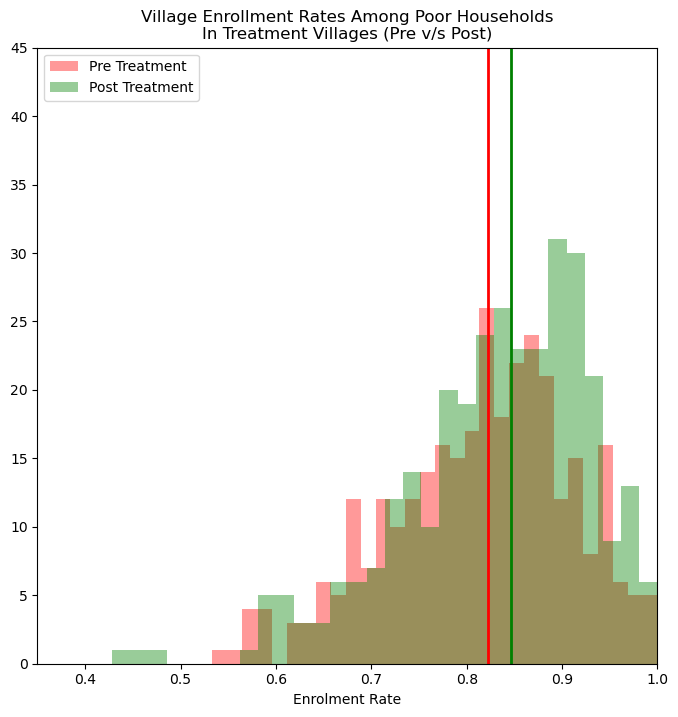

In [14]:
# Your code here
#print progresa_df.shape
poor_97 = progresa_df[(progresa_df['year'] == 97) &
                               (progresa_df['poor'] == 1) &
                               (progresa_df['progresa'] == 1)]
poor_98 = progresa_df[(progresa_df['year'] == 98) &
                               (progresa_df['poor'] == 1)  &
                               (progresa_df['progresa'] == 1)]

poor_97_en=pd.DataFrame(poor_97.groupby('village')['sc'].mean())
poor_98_en=pd.DataFrame(poor_98.groupby('village')['sc'].mean())

fig, ax = plt.subplots(figsize = (8, 8))

ax.hist(poor_97_en.values, color="red", bins=30, alpha = 0.4, label = 'Pre Treatment')
ax.hist(poor_98_en.values, color="green", bins=30, alpha = 0.4, label = 'Post Treatment')

# pre_mean = poor_treatment97_en['sc'].mean()
pre_mean = poor_97['sc'].mean()
plt.axvline(pre_mean, color="red", linewidth=2)

post_mean = poor_98['sc'].mean()
plt.axvline(post_mean, color="green", linewidth=2)

plt.ylim(0, 45)
plt.xlim(0.35, 1)
plt.xlabel("Enrolment Rate")

plt.legend()
plt.title("Village Enrollment Rates Among Poor Households\nIn Treatment Villages (Pre v/s Post)")
plt.show()

In [15]:
t, p = stats.ttest_ind(poor_97['sc'].dropna(), poor_98['sc'].dropna())
print('Difference:', (poor_98['sc'].mean()-poor_97['sc'].mean()))
print('p-value:', p)

Difference: 0.023782233992046597
p-value: 1.2976490728161e-09


In [16]:
t, p = stats.ttest_ind(poor_97['sc'].dropna(), poor_98['sc'].dropna(), equal_var=False)
print('Difference:', (poor_98['sc'].mean()-poor_97['sc'].mean()))
print('p-value:', p)

Difference: 0.023782233992046597
p-value: 1.1416386466097403e-09


On average, among poor households, enrollment rates increased by 2.3 p.p between 1997 and 1998. This difference in means was statistically significant at standard levels of stastical significance (p<0.05). Note that this doesn't necessary mean that the treatment had an impact, it just says that average enrollment rates were higher in the period post-treatment than they were in the period pre-treatment.

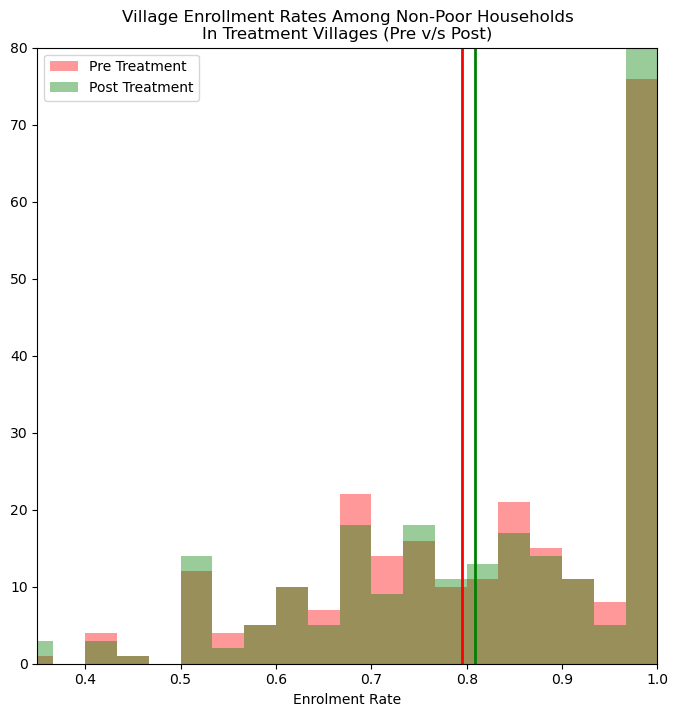

In [19]:
# Your code here
#print progresa_df.shape
nonpoor_97 = progresa_df[(progresa_df['year'] == 97) &
                               (progresa_df['poor'] == 0)  &
                               (progresa_df['progresa'] == 1) ]
nonpoor_98 = progresa_df[(progresa_df['year'] == 98)  &
                               (progresa_df['poor'] == 0)  &
                               (progresa_df['progresa'] == 1)]

nonpoor_97_en=pd.DataFrame(nonpoor_97.groupby('village')['sc'].mean())
nonpoor_98_en=pd.DataFrame(nonpoor_98.groupby('village')['sc'].mean())

fig, ax = plt.subplots(figsize = (8, 8))

ax.hist(nonpoor_97_en.values, color="red", bins=30, alpha = 0.4, label = 'Pre Treatment')
ax.hist(nonpoor_98_en.values, color="green", bins=30, alpha = 0.4, label = 'Post Treatment')

# pre_mean = poor_treatment97_en['sc'].mean()
pre_mean = nonpoor_97['sc'].mean()
plt.axvline(pre_mean, color="red", linewidth=2)

post_mean = nonpoor_98['sc'].mean()
plt.axvline(post_mean, color="green", linewidth=2)

plt.ylim(0, 80)
plt.xlim(0.35, 1)
plt.xlabel("Enrolment Rate")

plt.legend()
plt.title("Village Enrollment Rates Among Non-Poor Households\nIn Treatment Villages (Pre v/s Post)")
plt.show()

In [20]:
t, p = stats.ttest_ind(nonpoor_97['sc'].dropna(), nonpoor_98['sc'].dropna())
print('Difference:', (nonpoor_98['sc'].mean() - nonpoor_97['sc'].mean()))
print('p-value:', p)

Difference: 0.013784584782011833
p-value: 0.1737023474434498


On average among non-poor households (in treated villages), the difference in enrollment rates 1997 and 1998 is not statistically significant. 

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on school enrollment rates among the poor (those with poor=='pobre'), since only the poor were eligible to receive PROGRESA assistance, and since a primary objective of the program was to increase school enrollment.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [21]:
df98 = progresa_df[progresa_df['year'] == 98]
df97 = progresa_df[progresa_df['year'] == 97]

treated98 = df98[(df98.progresa == 1) & (df98.poor == 1)]
control98 = df98[(df98.progresa == 0) & (df98.poor == 1)]
mean_t98 = treated98.sc.mean()
mean_c98 = control98.sc.mean()

print('Control average (98): {}'.format(mean_c98))
print('Treated average (98): {}'.format(mean_t98))
print('Difference: {}'.format(mean_t98-mean_c98))
tstat, pval = stats.ttest_ind(treated98.sc.dropna(), control98.sc.dropna())
print('P-value: {}'.format(pval))

Control average (98): 0.807636956730308
Treated average (98): 0.8464791213954308
Difference: 0.0388421646651228
P-value: 6.636344447523235e-17


Enrollment rates among the poor in 1998 in the treated villages were nearly four percentage points higher than average enrollment rates in the control villages. These differences are statistically significant, so the "simple differences" method makes it look like Progresa  had an effect on enrollment. However, we are skeptical of these estimates, since we know that treatment villages were systematically different from control villages, even before the PROGRESA program arrived. In particular, poor households in the treated villages had higher rates of school enrollment in 1997, even before treatment had occured.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. For now, do not include any other variables in your regression. Discuss the following:

* Based on this model, how much did Progresa increase or decrease the likelihood of a child enrolling? Make sure you express you answer in a sentence that a person with no technical background could understand, using appropriate units.
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [24]:
poor98 = df98[df98.poor == 1]
ols1 = smf.ols(formula = "sc ~ progresa", data=poor98, missing='drop').fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           6.64e-17
Time:                        08:18:45   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

* The regression indicates that progresa increased enrollment of the poor by 3.88 percentage points
* Our estimate of the "simple differences" treatment effect of Progresa is identical to the estimate from 2.1
* Based on this regression model, we can reject the null hypothesis that the poor households in treated and control villages had the same levels of school enrollment in 1998. The estimate of 3.88 percentage points is highly significant (p<0.01). Note that we can only interpret this as the causal effect of treatment if we believe the identifying assumption, stated below
* The counterfactual assumption is that, in the absence of treatment, the average school enrollment in the treatment group and the average school enrollment in the control groups would have been the same.

### 2.3 Multiple Regression

Re-run the above regression, but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?
* Interpet the coefficient associated with the `dist_sec` variable. Is this evidence that the household's distance from a secondary school has a *causal* impact on educational attainment?

In [25]:
formula2 = "sc ~ progresa + age + dist_sec + C(sex) + hohedu + fam_n"
ols2 = smf.ols(formula2, data=poor98, missing='drop').fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     1644.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:18:51   Log-Likelihood:                -7742.1
No. Observations:               27440   AIC:                         1.550e+04
Df Residuals:                   27433   BIC:                         1.556e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5399      0.011    137.651

* Including control variables decreases the estimated coefficient on the treatment effect
* There is very little effect on the standard error
* Controlling for other observable factors decreased the estimated treatment effect - or put differently, without controlling for other factors, the estimates of the treatment effectin 2.2 were likely *over*-estimates of the true treatment effect. This is likely due to the fact that other factors were correlated with both treatment and outcomes (as we saw in 1.2).
* The -0.0112 coefficient associated with dist_sec indicates that with a unit increase in dist_sec the enrollment of poor on average decreases by 0.11%, holding all the other variables constant. This does not indicate a causal effect since dist_sec is the control variable which isn't randomly assigned and is only added to the regression to account for other systematic differences in the treatment and control groups.

### 2.4 Multiple Regression Revisited

For the same set of control variables that you used in 2.3, carry out the following alternative estimation procedure. 

* First, regress the 1998 enrollment of the poor on the control variables, **without including the treatment assignment.** 
* Second, use this model to obtain predicted values of the 1998 enrollment for each child in the sample used to estimate the model in step 1. 
* Third, compute a new value for each child, which is the difference between the actual 1998 enrollment and the predicted enrollment value from step 2. 
* Finally, regress the difference from step 3 on treatment assignment.

Compare the point estimate and the standard error on treatment assignment that you obtained in step 4 to their analogues in 2.3. Explain the results.

In [26]:
poor98_no_missing = poor98[["sc","progresa","age","dist_sec","sex","hohedu","fam_n"]].dropna()

formula2 = "sc ~ age + dist_sec + C(sex) + hohedu + fam_n"
ols2 = smf.ols(formula2, data=poor98_no_missing).fit()
print(ols2.summary())

y_hat = ols2.predict(exog = poor98_no_missing[["age","dist_sec","sex","hohedu","fam_n"]])

poor98_no_missing['diff'] = poor98_no_missing['sc'].values - y_hat
formula2 = "diff ~ progresa"
ols2 = smf.ols(formula2, data=poor98_no_missing).fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     1951.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:18:55   Log-Likelihood:                -7781.0
No. Observations:               27440   AIC:                         1.557e+04
Df Residuals:                   27434   BIC:                         1.562e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5621      0.011    143.108

The alternative estimation procedure yields very similar results as the multiple regression estimated in 2.3. We can think of multiple regression as providing an estimate of the linear relationssip between treatment assignment and the residual variance of the outcome that is not explained by the controls. 

### 2.5 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. 

Display your results in a 2x2 table where the rows are Control/Treatment and the columns are 1997/1998. 

* What is your difference-in-difference estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [28]:
poor_df = progresa_df[progresa_df['poor'] == 1]
poor_df_mean_sc = poor_df.groupby(['year', 'progresa'])['sc'].mean().reset_index()
print(poor_df_mean_sc,'\n')
dd_estimate = (poor_df_mean_sc.loc[3,'sc'] - poor_df_mean_sc.loc[2,'sc']) -\
              (poor_df_mean_sc.loc[1,'sc'] - poor_df_mean_sc.loc[0,'sc'])
print(dd_estimate)

   year  progresa     sc
0    97         0 0.8152
1    97         1 0.8227
2    98         0 0.8076
3    98         1 0.8465 

0.031331280319323085


In [29]:
temp_table = pd.DataFrame({'1997':[0.8152,0.8227], '1998':[0.8076,0.8465]}, index=['Control','Treatment'])
#temp_table['Dff'] = temp_table['1998']-temp_table['1997']
temp_table

,1997,1998
Control,0.8152,0.8076
Treatment,0.8227,0.8465


* Our double-different estimate is that PROGRESA increased enrolment by 3.13 percentage points. This estimate of the impact of PROGRESA is lower than the simple differences estimate from 2.2, and also lower than the simple difference estimate that controls for potentially confounding factors (2.3). Again, this all points to the fact that treated households were systematically different from control households, even in the absence of treatment. Most noticably, we previously estimated baseline differences in enrollment of 0.75%; of the various research designs we have tested, only the difference-in-difference estimator accounts for this.
* The counterfactual assumption is that in the absence of treatment, the average difference in enrollment for poor households in the treatment group between 1997 and 1998 would be the same as the average difference in enrollment for poor households in the control group between 1997 and 1998.  Another way of saying this is that we are assuming that there exist parallel trends over time in enrollment rates between treated and control villages.

### 2.6 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences, for the poor households. Do this (i) first without including any control variables; and then (ii) do it a second time including at least 5 control variables. 

* What is your estimate (i) of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* Does your estimate of the impact of Progresa from (i) change when you add control variables as in (ii)? How do you explain these changes, or the lack of changes on the `progresa` coefficient between (i) and (ii)?
* How do the estimates from (i) and (ii) compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences, if any exist?
* What is the counterfactual assumption underlying regression (ii)? 

In [30]:
poor_df = progresa_df[progresa_df.poor == 1].copy()
poor_df.year = np.where(poor_df.year == 97,0,1)
ols3 = smf.ols(formula='sc ~ progresa*year', data=poor_df, missing='drop').fit()
# note that in the above command [progresa*year] is a shorthand for [progresa + year + progresa X year] 
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.31
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           2.76e-18
Time:                        08:20:18   Log-Likelihood:                -26242.
No. Observations:               58372   AIC:                         5.249e+04
Df Residuals:                   58368   BIC:                         5.253e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8152      0.003    233.182

In [31]:
poor_df = progresa_df[progresa_df.poor == 1].copy()
poor_df.year = np.where(poor_df.year == 97,0,1)
ols3 = smf.ols(formula='sc ~ dist_cap + age + C(sex) + fam_n + hohedu + welfare_index + progresa*year', data=poor_df, missing='drop').fit()
# note that in the above command [progresa*year] is a shorthand for [progresa + year + progresa X year] 
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     2496.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:20:32   Log-Likelihood:                -16676.
No. Observations:               58200   AIC:                         3.337e+04
Df Residuals:                   58190   BIC:                         3.346e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3961      0.011    122.264

* Using a difference-in-difference regression in (i) without control variables, we estimate that the Progresa program increased enrollment of poor households by 3.13 percentage points (this is Progresa:year coefficient). The standard error is very low at 0.006 and the coefficient is highly statistically significant. Note that this is the same diff-in-diff estimate as we observed using cross-tabs earlier.
* The coefficient changes from 0.0313 to 0.031. Relative to the standard error of 0.006, these are small and statistically insignificant differences. The stability of our estimate of program impacts in the two difference-in-difference specifications is reassuring, as it indicates that the addition of these control variables is not changing/attenuating the estimated treatment effects, as it was in the single-difference specification.
* The estimated treatment effect from (i) is exactly the same as that estimated in 2.4. The treatment effect from (ii) changes a little, as we explained above, because of the fact that in this regression we are also controlling for other observed characteristics of the household (such as age, hohedu, etc.) which are also correlated with enrollment. 
* The counterfactual assumption is that, after accounting for the factors that we control for in the regression, in the absence of treatment, the difference in average enrollment in the treatment group between 1997 and 1998 would be the same as the average difference in enrollment in the control group.  Another way of saying this is that we are assuming that there exist parallel trends over time in enrollment rates between treated and control villages, conditional on the other variables in the regression

### 2.7 Heterogeneous Treatment Effects

Thus far, we have been calculating the average treatment effect -- implicitly assuming that the impacts of progresa are homogeneous (i.e similar for everyone in the treatment group).

However, treatment effects might vary by demographics, socio-economic status, or other covariates. In this exercise, we'll think a little more carefully about such variation in treatment effects, the aim being to arrive at a more nuanced understanding of who benefits most from progresa. (More formally, we are now thinking of *conditional* average treatment effects -- a concept that you will revisit towards the end of the semester).

Repeat your analysis in 2.5 / 2.6, instead focusing on whether the impacts of Progresa on school enrolment differ by gender.

1. Begin by estimating the average treatment effects of the program for male children in poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among male children in poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among male children in poor households in control villages.
    - Report your results in a 2 X 2 table where the rows are Control / Treatment, and the columns are 1997 / 1998.
    - Report your estimate of the causal impact of progresa on school enrolment for male children.

2. Repeat the process for female children in poor households using data from 1997 and 1998.
    - Report the results in a 2 X 2 table where the rows are Control / Treatment, and the columns are 1997 / 1998.
    - Report your estimate of the causal impact of progresa on school enrolment for male children.

3. Do the effects of Progresa differ by gender?
    - Begin by examining manually examining the differences in the causal impact of progresa on school enrolment for male and female children (from Steps 1 and 2 above ).  
    - Then, extend the double difference regression you ran in 2.6 (without including any control variables) to directly estimate the differential impact. (Hint: the double difference / diff-in-diff regression you have seen in class and lab sessions allow you to compare two groups (treated and control) across two time periods (pre and post). Now, within this setup, you have an additional comparison to make – between male and female children. What terms do you need to add to the regression in 2.6 in order to allow for this third axis of comparison?)
    - Report your findings – do the effects of Progresa differ by gender? 



In [51]:
#1. 

mtable = poor_df[poor_df.sex == 1].groupby(['progresa', 'year']).sc.mean().reset_index()
display(mtable.pivot(index = 'progresa', columns = 'year'))
mimpact = (0.8571 - 0.8370) - (0.8218 - 0.8320)
print("Causal impact of Progresa on Male Children:", mimpact)

sc       
year          0      1
progresa              
0        0.8320 0.8218
1        0.8370 0.8571

Causal impact of Progresa on Male Children: 0.030299999999999994


In [52]:
#2. 

ftable = poor_df[poor_df.sex == 0].groupby(['progresa', 'year']).sc.mean().reset_index()
display(ftable.pivot(index = 'progresa', columns = 'year'))
fimpact = (0.8350 - 0.8071) - (0.7930 - 0.7982)
print("Causal impact of Progresa on Female Children:", fimpact)

sc       
year          0      1
progresa              
0        0.7982 0.7930
1        0.8071 0.8350

Causal impact of Progresa on Female Children: 0.03309999999999991


In [53]:
# 3. Differential impacts by gender:
mimpact - fimpact

-0.0027999999999999137

In [54]:
# Regression version
poor_df = progresa_df[progresa_df.poor == 1].copy()
poor_df.year = np.where(poor_df.year == 97,0,1)
ols3_het = smf.ols(formula='sc ~ progresa*year*C(sex)', data=poor_df, missing='drop').fit() ## note the additional interaction

ols3_het.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     23.91
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           1.01e-32
Time:                        08:28:02   Log-Likelihood:                -26189.
No. Observations:               58352   AIC:                         5.239e+04
Df Residuals:                   58344   BIC:                         5.247e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7982      0.005    160.550      0.000       0.788       0.808
C(sex)[T.1.0]                   0.0338      0.007      4.830      0.000       0.020       0.047
progresa                        0.0089      0.006      1.406      0.160      -0.004       0.021
progresa:C(sex)[T.1.0]         -0.0039      0.009     -0.437      0.662      -0.021       0.014
year                           -0.0052      0.007     -0.715      0.474      -0.019       0.009
year:C(sex)[T.1.0]             -0.0049      0.010     -0.483      0.629      -0.025       0.015
progresa:year                   0.0330      0.009      3.560      0.000       0.015       0.051
progresa:year:C(sex)[T.1.0]    -0.0028      0.013     -0.216      0.829      -0.028       0.023
==============================================================================
Omnibus:                    15305.553   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30480.686
Skew:                          -1.707   Prob(JB):                         0.00
Kurtosis:                       3.935   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



In order to see examine the differential effects of Progresa by gender, we extend our diff-in-diff regression by adding an interaction with the gender dummy. This is now a triple difference in difference specification. 

In the regression we run above:
 - the coefficient progresa X year X C(sex)[T.1.0] tells us the differential impact of progresa by gender. 
 - while the magnitude of this coefficient matches the results from our manual calculations, the coefficent is not statistically significant.

Based on our analysis, we conclude the effects of Progresa do not differ by gender. 

### 2.8 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico? 

Using several different empirical frameworks, we have explored the impact of the PROGRESA program on enrollment rates of poor households in Mexico. In general, it appears that PROGRESA did have positive impact on the school enrollment rates, though the exact estimate depends on the method used to measure impact. After controlling for other observable characteristics, the most reliable difference-in-difference estimator estimates that PROGRESA raised enrollment rates by roughly 3.13 percentage points. A separate estimator, that includes externalities on non-poor households, produces a more conservative, and statistically insignificant, estimate.

### 2.9 Spillover effects [EXTRA CREDIT]

Thus far, we have focused on the impact of PROGRESA on the school enrollment of poor households. Repeat your analysis in 2.5, instead focusing on (a) the impact of PROGRESA on the school enrollment of non-poor households, and (b) the impact ofo PROGRESA on *other outcomes* of poor households that might plausibly have been affected by the PROGRESA program.
* Do you observe any impacts of PROGRESA on the school enrollment of the non-poor?
* Regardless of whether you find evidence of spillovers to non-poor, describe one or two reasons why PROGRESA *might* have impacted non-poor households. Give concrete examples based on the context in which PROGRESA was implemented.
* Do you observe any impacts of PROGRESA on other aspects of the welfare of poor households? 

In [33]:
nonpoor_df = progresa_df[progresa_df.poor == 0].copy()
nonpoor_df.year = np.where(nonpoor_df.year == 97, 0, 1)
ols4 = smf.ols(formula='sc ~ progresa*year',data=nonpoor_df).fit()
print(ols4.summary())
ols5 = smf.ols(formula='sc ~ age + C(sex) + fam_n + hohedu + progresa*year',data=nonpoor_df).fit()
print(ols5.summary())
ols6 = smf.ols(formula='hohedu ~ progresa*year',data = poor_df).fit()
print(ols6.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.332
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           0.000276
Time:                        22:05:11   Log-Likelihood:                -5448.5
No. Observations:               10425   AIC:                         1.090e+04
Df Residuals:                   10421   BIC:                         1.093e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7626      0.009     89.682

* Using this simple difference-in-difference strategy, we do not observe any statistically different impacts of PROGRESA on the non-poor.
* PROGRESA could have benefited non-poor households for several reasons. For instance, if the PROGRESA program improved overall school quality (for all students) in treated villages, this would benefit poor and non-poor alike. Alternatively, if non-poor households were somehow able to cheat the assignment rule and receive the subsidy, they would benefit from imperfect treatment compliance.
* Can consider any of the columns from monthly wages of family head, number of years in school etc , I have considered years of schooling. PROGRESA doesnt have impact

In [37]:
poor_df['sc'].unique()

array([ 1.,  0., nan])

In [64]:
import json

with open('C:/Users/suraj/Downloads/Yan_Yufeng-PS1.ipynb', 'r') as f:
    notebook = json.load(f)
    
# Check metadata if it exists
if 'metadata' in notebook:
    print(notebook['metadata'])

{'jupytext': {'formats': 'ipynb,py:light'}, 'kernelspec': {'display_name': 'Python 3 (ipykernel)', 'language': 'python', 'name': 'python3'}, 'language_info': {'codemirror_mode': {'name': 'ipython', 'version': 3}, 'file_extension': '.py', 'mimetype': 'text/x-python', 'name': 'python', 'nbconvert_exporter': 'python', 'pygments_lexer': 'ipython3', 'version': '3.11.11'}}


In [65]:
import os
from datetime import datetime

# Get file creation time (Windows) or metadata change time (Unix)
creation_time = os.path.getctime('C:/Users/suraj/Downloads/Yan_Yufeng-PS1.ipynb')

# Convert timestamp to readable date
creation_date = datetime.fromtimestamp(creation_time)
print(f"File creation date: {creation_date}")

File creation date: 2025-02-10 16:13:31.408048
